In [33]:
import pandas as pd
import numpy as np

df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # 임상 정보
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # 트랙 목록
df_labs = pd.read_csv('https://api.vitaldb.net/labs')  # lab 데이터

In [34]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) &
    set(df_labs[df_labs['name'] == 'wbc']['caseid'])
)

caseids = caseids[:100]
print('Total {} cases found'.format(len(caseids)))

Total 100 cases found


In [38]:
# Set blood pressure threshold
mbp_thresholds = np.arange(40, 80)
rows = []

# Save the final result
df = pd.DataFrame()
for caseid in caseids:
    print('loading {}...'.format(caseid), flush=True, end='')

    # Column ['anend'] : anesthesia end time
    aneend = df_cases[(df_cases['caseid'] == caseid)]['aneend'].values[0]

    # Maximum creatinine concentration within 48 hours after surgery
    postop_wbc = df_labs[(df_labs['caseid'] == caseid) & (df_labs['dt'] > aneend) &
        (df_labs['dt'] < aneend + 48 * 3600) & (df_labs['name'] == 'wbc')]['result'].max(skipna=True)
    if not postop_wbc or np.isnan(postop_wbc):
        print('no postop wbc')
        continue

    # WBC 12 x 10³/uL 초과시 mins = True
    high_wbc = postop_wbc > 12

    # Blood pressure during surgery
    tid_mbp = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/ART_MBP')]['tid'].values[0]
    mbps = pd.read_csv('https://api.vitaldb.net/' + tid_mbp).values[:,1]
    mbps = mbps[~np.isnan(mbps)]
    mbps = mbps[(mbps > 20) & (mbps < 150)]
    if len(mbps) < 10:
        print('no mbp')
        continue

    # Calculate the percentage that stays for the time as increasing the blood pressure by 1 unit.
    row = {'high_wbc':high_wbc}
    for mbp_threshold in mbp_thresholds:
        row['under{}'.format(mbp_threshold)] = np.nanmean(mbps < mbp_threshold) * 100
    rows.append(row)

    # Append the result into row
    print('{}, {}'.format(postop_wbc, 'HIGH WBC' if high_wbc else ''))

df = pd.DataFrame(rows)
print('{} HIGH WBC {:.1f}%'.format(df['high_wbc'].sum(), df['high_wbc'].mean() * 100))

loading 1...15.16, HIGH WBC
loading 4...11.65, 
loading 7...12.89, HIGH WBC
loading 10...13.38, HIGH WBC
loading 12...19.74, HIGH WBC
loading 13...14.83, HIGH WBC
loading 14...no postop wbc
loading 16...12.55, HIGH WBC
loading 17...16.27, HIGH WBC
loading 19...15.92, HIGH WBC
loading 20...48.59, HIGH WBC
loading 22...9.8, 
loading 24...8.92, 
loading 25...23.63, HIGH WBC
loading 26...14.6, HIGH WBC
loading 27...no postop wbc
loading 28...8.79, 
loading 29...9.79, 
loading 31...11.46, 
loading 32...no postop wbc
loading 34...no postop wbc
loading 38...11.97, 
loading 41...13.12, HIGH WBC
loading 43...12.21, HIGH WBC
loading 44...12.19, HIGH WBC
loading 46...14.74, HIGH WBC
loading 49...11.13, 
loading 50...11.98, 
loading 51...9.01, 
loading 52...13.88, HIGH WBC
loading 53...14.17, HIGH WBC
loading 55...19.51, HIGH WBC
loading 56...19.2, HIGH WBC
loading 58...13.53, HIGH WBC
loading 60...8.55, 
loading 61...7.74, 
loading 64...11.73, 
loading 65...13.41, HIGH WBC
loading 66...7.59, 
loa

In [39]:
# Get odd ration using univariate logistic regression
import statsmodels.api as sm
df['intercept'] = 1
df['high_wbc'] = df['high_wbc'].astype(bool)
odd_ratios = []
for mbp_threshold in mbp_thresholds:
    c = 'under{}'.format(mbp_threshold)
    model = sm.Logit(df['high_wbc'], df[['intercept', c]])
    res = model.fit()
    b = res.params[c]
    pval = res.pvalues[c]
    odd_ratios.append(np.exp(b))
    print('{}\tb={:.3f}, exp(b)={:.3f}, pval={:.3f}'.format(c, b, np.exp(b), pval))

Optimization terminated successfully.
         Current function value: 0.683418
         Iterations 6
under40	b=0.287, exp(b)=1.333, pval=0.447
Optimization terminated successfully.
         Current function value: 0.683098
         Iterations 6
under41	b=0.288, exp(b)=1.333, pval=0.437
Optimization terminated successfully.
         Current function value: 0.682700
         Iterations 6
under42	b=0.296, exp(b)=1.344, pval=0.421
Optimization terminated successfully.
         Current function value: 0.681999
         Iterations 6
under43	b=0.315, exp(b)=1.371, pval=0.401
Optimization terminated successfully.
         Current function value: 0.681762
         Iterations 6
under44	b=0.309, exp(b)=1.362, pval=0.388
Optimization terminated successfully.
         Current function value: 0.681091
         Iterations 6
under45	b=0.321, exp(b)=1.379, pval=0.368
Optimization terminated successfully.
         Current function value: 0.679864
         Iterations 6
under46	b=0.347, exp(b)=1.414, pva

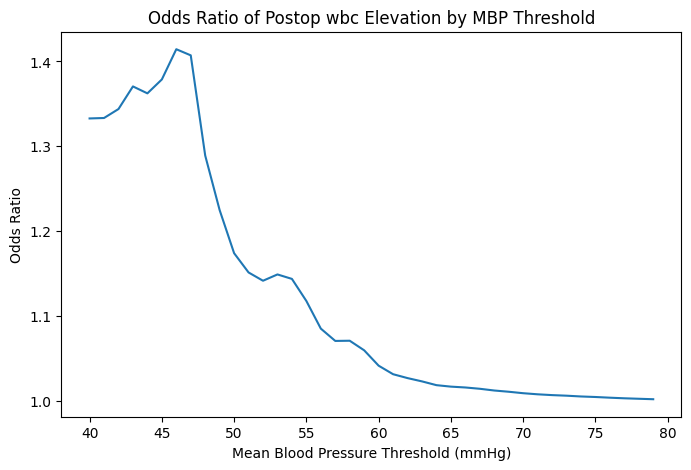

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(mbp_thresholds, odd_ratios)
plt.xlabel('Mean Blood Pressure Threshold (mmHg)')
plt.ylabel('Odds Ratio')
plt.title('Odds Ratio of Postop wbc Elevation by MBP Threshold')
plt.show()